In [27]:
import numpy as np
import sklearn as sk

# read .mat files
import scipy.io as sio
train = sio.loadmat('../data/train_32x32.mat')
test = sio.loadmat('../data/test_32x32.mat')

# extract data and labels
train_data: np.ndarray = train['X']
train_labels: np.ndarray = train['y']
test_data: np.ndarray = test['X']
test_labels: np.ndarray = test['y']

In [50]:
trd_reshape = train_data.reshape(3072, train_data.shape[3]).T
ted_reshape = test_data.reshape(3072, test_data.shape[3]).T
zipped = list(zip(trd_reshape, train_labels))
np.random.shuffle(zipped)
srt = sorted(zipped, key=lambda x: x[1])
print(len(srt))
out = []
labels = []
x = -1
for i, q in enumerate(srt):
  if q[1] != x:
    # New label
    out += list(map(lambda w: w[0], srt[i:i+2500]))
    labels += list(map(lambda w: w[1], srt[i:i+2500]))
    x = q[1]

trd_new = out
print(len(out), len(labels))

73257
25000 25000


In [48]:
# Weird numpy errors. Above one works.
# Nuke at will.

out = []
rlabels = []
x = 1
j = 0
rand = []
for i, q in enumerate(srt):
  if q[1][0] != x:
    # New label
    # print(i, j, q[1][0], x)
    r = np.random.choice(j - i, 2500)
    # out += [srt[j:i]]
    rand += [srt[r]]
    j = i
    x = q[1][0]
out += [srt[j:]]

# We have all the stuff.
# rand = list(map(lambda x: [np.random.choice(x, 2500)], out))
# print(out[0].shape)
# rand = []
# for bunch in out:
#   rb = np.random.choice(bunch, 2500)
#   rand += list(rb)

print(len(rand))


ValueError: a must be greater than 0 unless no samples are taken

In [29]:
from sklearn.decomposition import PCA


def train_pca(i) -> (PCA, np.ndarray, np.ndarray):
    pca = PCA(n_components=i)
    pca.fit(trd_new)
    train_data_pca = pca.transform(trd_new)
    test_data_pca = pca.transform(ted_reshape)
    return pca, train_data_pca, test_data_pca


PoV = 0.900 > 0.9 achieved at 26 dimensions


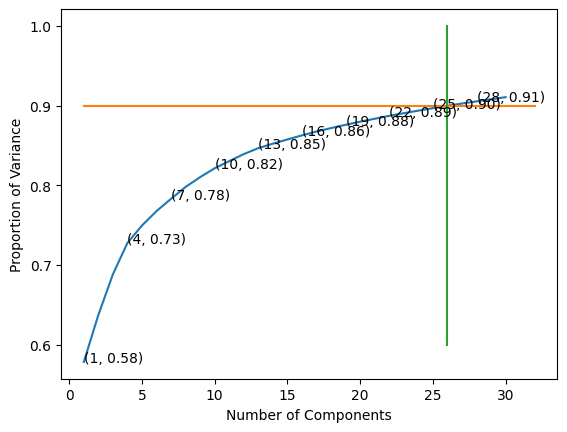

In [30]:

# We estimate (correctly) that the required dimension < 30.
pca, tr, te = train_pca(30)
q = np.cumsum(pca.explained_variance_ratio_)

import matplotlib.pyplot as plt
plt.plot(range(1, 31), q)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance') #for each component
v = 0
for i in range(1, 31, 3):
    plt.annotate(f'({i}, {q[i-1]:.2f})', (i, q[i-1]))
    if q[i-1] >= 0.9:
        v = i
        break

plt.plot(np.linspace(1, 32, 320), [0.9] * 320)
plt.plot([v - 2] * 320, np.linspace(0.6, 1.0, 320))
print(f'PoV = {q[25]:.3f} > 0.9 achieved at {v - 2} dimensions')
plt.show()

In [31]:
pca, tr_pca_1, te_pca_1 = train_pca(v - 2)
pca, tr_pca_2, te_pca_2 = train_pca(10)

In [32]:
tr_pca_1.shape, te_pca_1.shape, tr_pca_2.shape, te_pca_2.shape

((25000, 26), (26032, 26), (25000, 10), (26032, 10))

In [33]:
# This should be images, maybe refer Rutv's code.

# print(pca.components_)
# print(pca.explained_variance_)
# imgs = pca.components_.reshape(10, 32, 32, 3)
# for img in imgs:
#     print(img[0][0])
#     plt.imshow(img)

In [34]:
# zipped = list(zip(tr_pca_2, train_labels))
# srt = sorted(zipped, key=lambda x: x[1])
# # print(srt[0])
# x = -1
# for i in srt:
#     if i[1] != x:
#         print(list(i[0]))
#         x = i[1]

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
def knn(k) -> (float, float, float):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(trd_new, labels)
    x = accuracy_score(test_labels, knn.predict(ted_reshape))
    knn.fit(tr_pca_1, labels)
    y = accuracy_score(test_labels, knn.predict(te_pca_1))
    knn.fit(tr_pca_2, labels)
    z = accuracy_score(test_labels, knn.predict(te_pca_2))
    return (x, y, z)

(knn(5), knn(7))

/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

((0.40277350952673635, 0.39535955746773205, 0.25195912722802705),
 (0.41160878918254457, 0.40769053472649047, 0.2609096496619545))

In [49]:
np.savetxt('tr_pca_2.csv', tr_pca_1, delimiter=',') # The dimensions = 10 dataset.